In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet, HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ttest_rel


In [2]:

# ================== 数据预处理 ==================
def preprocess_data(df):
    """数据预处理函数"""
    # 删除不需要的列
    df = df.drop(columns=['local_authority_name_encoded', 'local_authority_name'])
    # 添加时间相关特征
    df['year'] = pd.to_datetime(df['year'], format='%Y').dt.year
    return df.dropna()

# 读取数据
data = pd.read_csv('datasets/eTraffic_final_lag2_v4.csv')
data_processed = preprocess_data(data)

# ================== 特征工程 ==================
class FeatureEngineer:
    """自定义特征工程转换器"""
    def fit(self, X, y=None):
        self.combinations = [
            ('HGVs_3_or_4_articulated_axle', 'LGVs'),
            ('buses_and_coaches', 'HGVs_2_rigid_axle')
        ]
        return self
    
    def transform(self, X):
        for f1, f2 in self.combinations:
            X[f'{f1}_ratio_{f2}'] = X[f1] / (X[f2] + 1e-6)
        return X

# ================== 数据划分 ==================
X = data_processed.drop(columns=['GDP'])
y = data_processed['GDP']

# 随机划分数据集（测试集占比20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42
)


In [3]:
data.columns

Index(['local_authority_name', 'year', 'pedal_cycles',
       'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches',
       'LGVs', 'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle',
       'HGVs_4_or_more_rigid_axle', 'HGVs_3_or_4_articulated_axle',
       'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'all_HGVs',
       'all_motor_vehicles', 'GDP', 'local_authority_name_encoded'],
      dtype='object')

In [4]:
# 检查所有非数值列
non_numeric = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("非数值特征列:", non_numeric)

非数值特征列: []


In [5]:
X_train.columns

Index(['year', 'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
       'buses_and_coaches', 'LGVs', 'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle',
       'HGVs_4_or_more_rigid_axle', 'HGVs_3_or_4_articulated_axle',
       'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'all_HGVs',
       'all_motor_vehicles'],
      dtype='object')

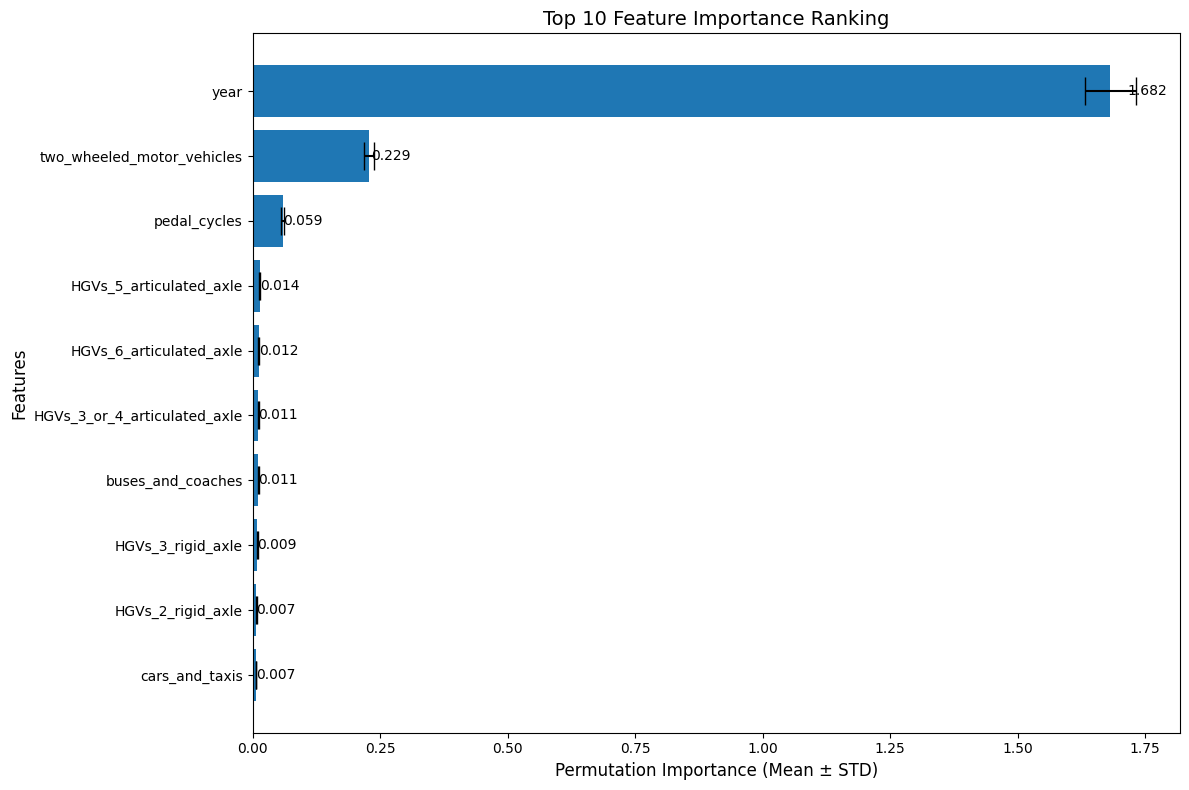

自动筛选结果（前10特征）： ['year', 'two_wheeled_motor_vehicles', 'pedal_cycles', 'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'HGVs_3_or_4_articulated_axle', 'buses_and_coaches', 'HGVs_3_rigid_axle', 'HGVs_2_rigid_axle', 'cars_and_taxis']
如需调整，请直接修改 selected_features 列表

最终保留特征数: 10
特征列表: ['year', 'two_wheeled_motor_vehicles', 'pedal_cycles', 'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'HGVs_3_or_4_articulated_axle', 'buses_and_coaches', 'HGVs_3_rigid_axle', 'HGVs_2_rigid_axle', 'cars_and_taxis']


In [6]:
# ================== 特征筛选 ==================

# 初始化随机森林模型
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)

# 计算排列重要性（增加重复次数以提高稳定性）
perm_importance = permutation_importance(
    base_model, X_train, y_train,
    n_repeats=10,       # 增加重复次数
    random_state=42,
    n_jobs=-1           # 启用并行加速
)

# 生成特征重要性数据框，使用 X_train 中的原始特征名称
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

# 选取排列重要性排名前 10 的特征（保持原始特征名称）
top_features = importance_df.head(10)

plt.figure(figsize=(12, 8))
bars = plt.barh(
    top_features['feature'], 
    top_features['importance_mean'],
    xerr=top_features['importance_std'],
    capsize=10
)
plt.xlabel('Permutation Importance (Mean ± STD)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 10 Feature Importance Ranking', fontsize=14)
plt.gca().invert_yaxis()  # 将最重要特征显示在顶部

# 为每个条形添加数值标签
for bar in bars:
    width = bar.get_width()
    plt.text(
        width * 1.02, 
        bar.get_y() + bar.get_height()/2,
        f'{width:.3f}',
        va='center'
    )
plt.tight_layout()
plt.show()

# 自动筛选结果：直接选择前 10 个原始特征
selected_features = importance_df.head(10)['feature'].tolist()

print("自动筛选结果（前10特征）：", selected_features)
print("如需调整，请直接修改 selected_features 列表")

# 应用特征筛选
X_train_filtered = X_train[selected_features].copy()
X_test_filtered = X_test[selected_features].copy()

print(f"\n最终保留特征数: {len(selected_features)}")
print("特征列表:", selected_features)


In [7]:
top_features

,feature,importance_mean,importance_std
0,year,1.681945,0.049950
2,two_wheeled_motor_vehicles,0.228834,0.009877
1,pedal_cycles,0.058906,0.003492
10,HGVs_5_articulated_axle,0.013853,0.000773
11,HGVs_6_articulated_axle,0.011935,0.001116
9,HGVs_3_or_4_articulated_axle,0.011457,0.000860
4,buses_and_coaches,0.011092,0.001099
7,HGVs_3_rigid_axle,0.009083,0.000829
6,HGVs_2_rigid_axle,0.007294,0.000530
3,cars_and_taxis,0.006649,0.000714


所选特征: ['HGVs_6_articulated_axle', 'HGVs_5_articulated_axle', 'HGVs_3_or_4_articulated_axle', 'two_wheeled_motor_vehicles', 'pedal_cycles', 'buses_and_coaches']

Training Ridge...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
最佳参数: {'model__alpha': np.float64(0.49417133613238334), 'model__solver': 'auto'}


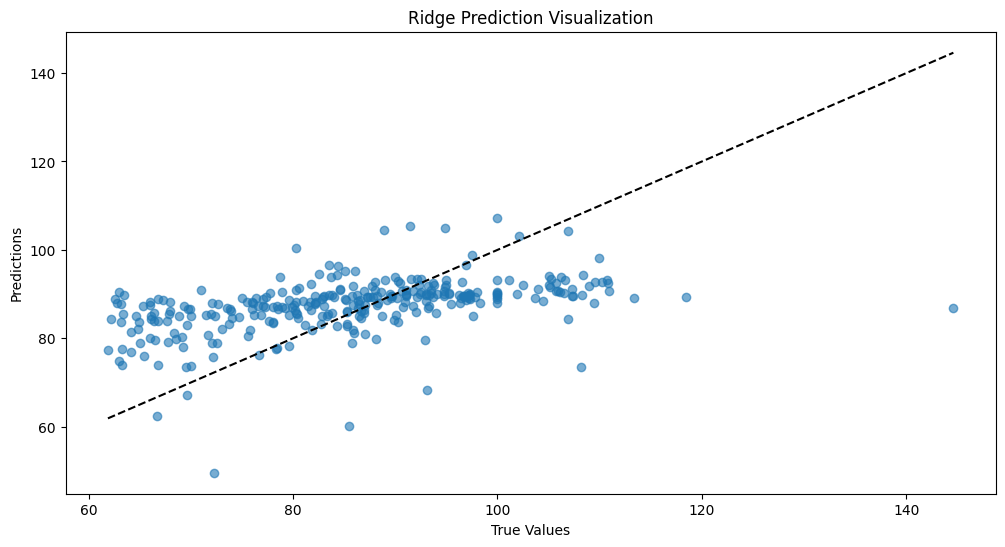


Training ElasticNet...
Fitting 5 folds for each of 250 candidates, totalling 1250 fits
最佳参数: {'model__alpha': np.float64(0.0030888435964774815), 'model__l1_ratio': 0.9}


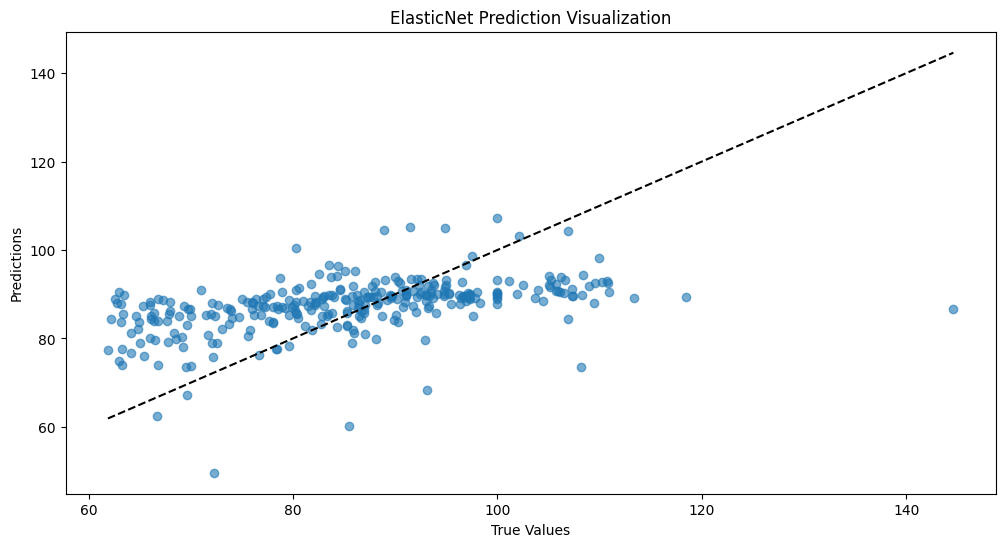


Training HuberRegressor...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
最佳参数: {'model__alpha': np.float64(1.438449888287663), 'model__epsilon': 1.5}


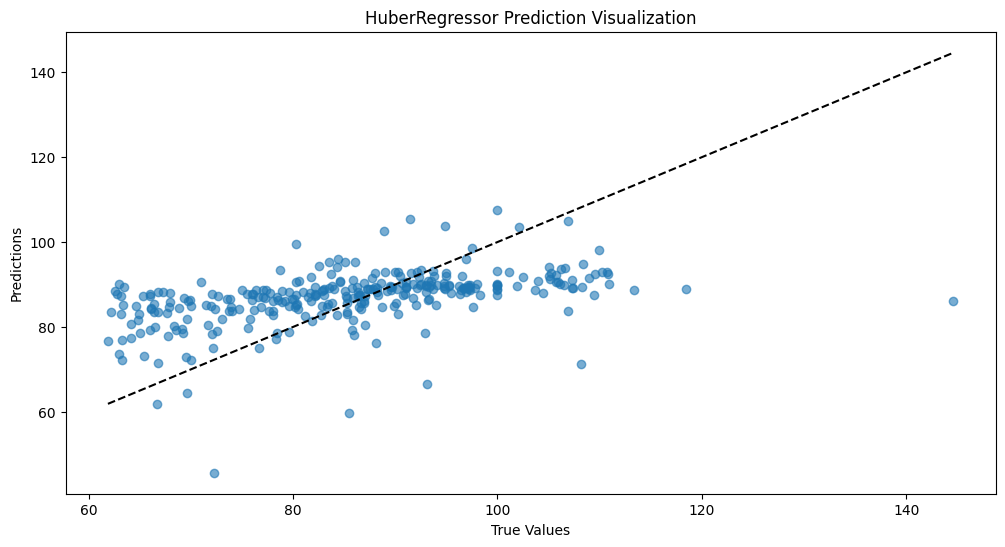

In [10]:
# 假设 FeatureEngineer 为自定义特征工程类（这里只给出一个占位实现）
class FeatureEngineer:
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X
    def fit_transform(self, X, y=None):
        return self.transform(X)

# ---------------- 特征筛选 ----------------
# 根据排列重要性建议选择的核心特征
selected_features = ['HGVs_6_articulated_axle', 'HGVs_5_articulated_axle', 'HGVs_3_or_4_articulated_axle',
                     'two_wheeled_motor_vehicles', 'pedal_cycles', 'buses_and_coaches']

# 假设 X_train, y_train, X_test, y_test 已加载，并包含所有原始特征
# 这里只保留 selected_features
X_train = X_train[selected_features].copy()
X_test = X_test[selected_features].copy()

print("所选特征:", selected_features)

# ================== 模型配置 ==================
models = {
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(max_iter=10000),
    "HuberRegressor": HuberRegressor()
}

param_grids = {
    "Ridge": {
        'model__alpha': np.logspace(-3, 3, 50),
        'model__solver': ['auto', 'svd']
    },
    "ElasticNet": {
        'model__alpha': np.logspace(-3, 3, 50),
        'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    },
    "HuberRegressor": {
        'model__alpha': np.logspace(-3, 3, 20),
        'model__epsilon': [1.1, 1.35, 1.5]
    }
}

# ================== 流水线构建 ==================
pipelines = {
    model_name: Pipeline([
        ('engineer', FeatureEngineer()),  # 特征工程
        ('scaler', StandardScaler()),     # 数据标准化
        ('model', models[model_name])      # 模型
    ]) for model_name in models
}

# ================== 模型训练与评估 ==================
results = []
predictions = {}
best_models = {}  # 用于存储每个模型的最佳流水线

for model_name in models:
    print(f"\n{'='*40}\nTraining {model_name}...\n{'='*40}")
    
    pipeline = pipelines[model_name]
    grid = GridSearchCV(
        pipeline,
        param_grids[model_name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    print(f"最佳参数: {grid.best_params_}")
    
    best_models[model_name] = grid.best_estimator_
    best_model = best_models[model_name]
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    predictions[model_name] = y_test_pred
    
    # 记录评估结果
    train_metrics = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred) * 100,
        'Train R2': r2_score(y_train, y_train_pred)
    }
    test_metrics = {
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Test MAPE': mean_absolute_percentage_error(y_test, y_test_pred) * 100,
        'Test R2': r2_score(y_test, y_test_pred)
    }
    results.append(pd.DataFrame({**train_metrics, **test_metrics}, index=[model_name]))
    
    # 可视化预测结果
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'{model_name} Prediction Visualization')
    plt.show()



模型性能对比:
                Train MAE   Train MSE  Train MAPE  Train R2  Test MAE  \
HuberRegressor   8.869793  134.790672   10.347405  0.266931  9.074641   
ElasticNet       8.899459  134.203207   10.431926  0.270126  9.178801   
Ridge            8.899036  134.202592   10.431238  0.270129  9.178880   

                  Test MSE  Test MAPE   Test R2  
HuberRegressor  135.564662  11.076411  0.213220  
ElasticNet      137.067394  11.255997  0.204499  
Ridge           137.087412  11.255638  0.204383  

统计显著性检验（与真实值比较）:
                       Test Result
Ridge           t=-2.74 (p=0.0065)
ElasticNet      t=-2.74 (p=0.0065)
HuberRegressor  t=-2.06 (p=0.0404)


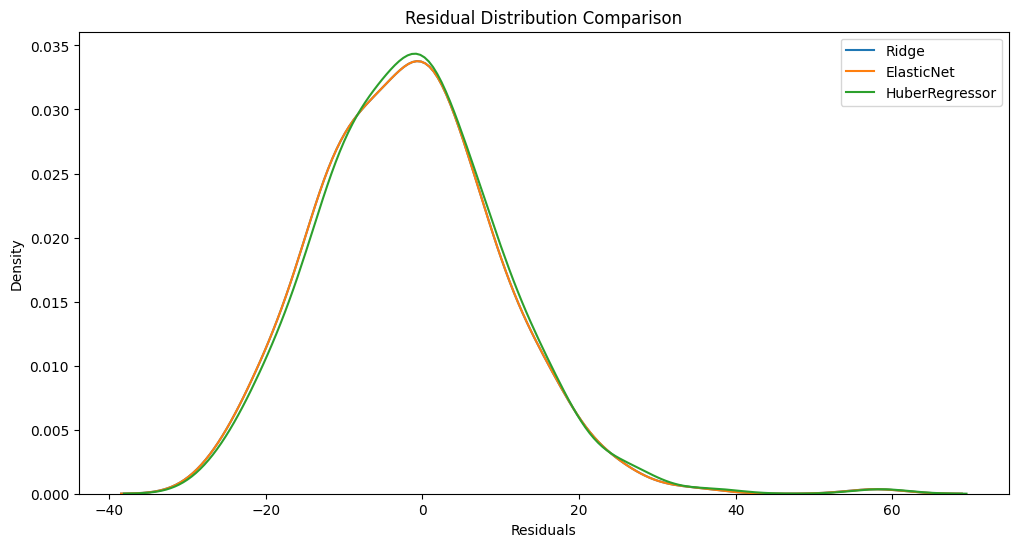

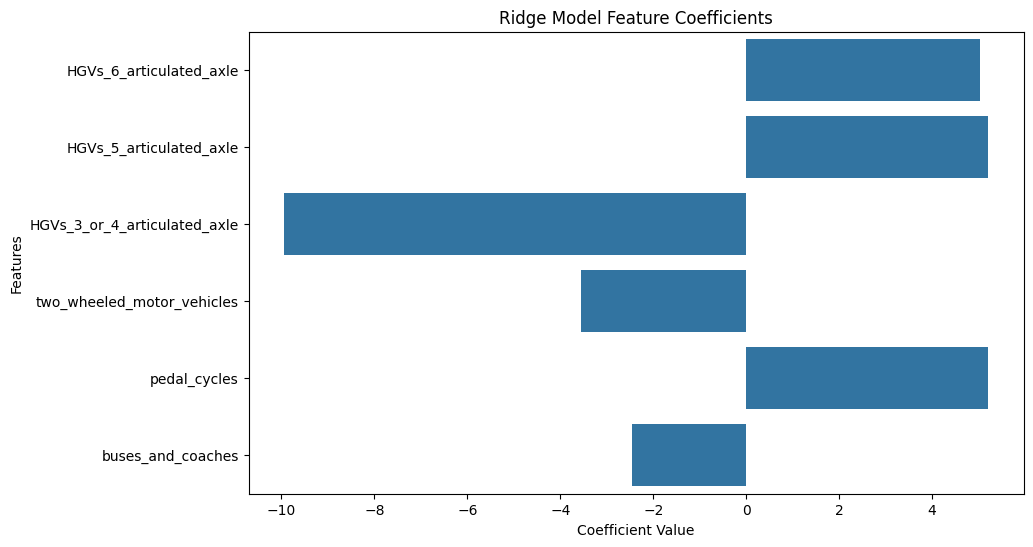

In [11]:

# ================== 结果分析 ==================
# 合并评估结果
results_df = pd.concat(results)
print("\n模型性能对比:")
print(results_df.sort_values('Test MSE'))

# 统计显著性检验
def statistical_validation(y_true, pred_dict):
    results = {}
    baseline = pred_dict['Ridge']
    for name, pred in pred_dict.items():
        t_stat, p_val = ttest_rel(y_true, pred)
        results[name] = f"t={t_stat:.2f} (p={p_val:.4f})"
    return results

print("\n统计显著性检验（与真实值比较）:")
print(pd.DataFrame.from_dict(statistical_validation(y_test, predictions), orient='index', columns=['Test Result']))

# 残差分析
plt.figure(figsize=(12, 6))
for model_name, pred in predictions.items():
    residuals = y_test - pred
    sns.kdeplot(residuals, label=model_name)
plt.title('Residual Distribution Comparison')
plt.xlabel('Residuals')
plt.legend()
plt.show()

# 特征重要性可视化（以 Ridge 模型为例）
# 从最佳的 Ridge 模型中提取训练好的模型
ridge_model = best_models["Ridge"].named_steps['model']
features = X_train.columns.tolist()

plt.figure(figsize=(10, 6))
sns.barplot(x=ridge_model.coef_, y=features)
plt.title('Ridge Model Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()
